In [ ]:
!pip -q install opencv-contrib-python --upgrade

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

import os
import time
from datetime import datetime
import json
import shutil
from typing import *

import googledrivedownloader as gdd

In [ ]:
def get_progress_bar(value: int, total: int, len=20):
  progress = value * len // total
  remaining = len - progress
  progress_str = "=" * progress
  remaining_str = " " * remaining
  return "[" + progress_str + remaining_str + "]"

def download_dataset(name: str, gdrive_id: str, unzip=True):
  if os.path.isfile(name):
    print("{} already downloaded.".format(name))
    return

  gdd.download_file_from_google_drive(file_id=gdrive_id, dest_path="/content/" + name, unzip=unzip)

def download_datasets(names_dict: Dict[str, str], unzip=True):
  for name, gdrive_id in names_dict.items():
    download_dataset(name, gdrive_id, unzip)

## CASIA-WebFace

In [ ]:
download_dataset("./cropped-webface-128_1000.zip", "1PR1Mhi6uUyrVUP5HDmHJvXVQqz-izNJ4")

Unzipping...Done.


In [ ]:
download_dataset("./cropped-webface-16_1000.zip", "1gwHNOMbZ2_6VDUYmdO6LQG4OlyKAHTz6")

Unzipping...Done.


In [ ]:
params = { "image_size": (128, 128), "shuffle": True, "validation_split": .2, "seed": 42 }

cropped_webface_train_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/cropped-webface-128_1000", subset="training", **params)
cropped_webface_validate_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/cropped-webface-128_1000", subset="validation", **params)

Found 73809 files belonging to 1000 classes.
Using 59048 files for training.
Found 73809 files belonging to 1000 classes.
Using 14761 files for validation.


In [ ]:
params = { "image_size": (16, 16), "shuffle": True, "validation_split": .2, "seed": 42 }

cropped_webface_small_train_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/cropped-webface-32_1000", subset="training", **params)
cropped_webface_small_validate_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/cropped-webface-32_1000", subset="validation", **params)

Found 73809 files belonging to 1000 classes.
Using 59048 files for training.
Found 73809 files belonging to 1000 classes.
Using 14761 files for validation.


## LFW

In [ ]:
download_dataset("./cropped-lfw-128.zip", "1vl_wEEmQec0hZr45XNBEAS5ZQsKIFhsZ")

Unzipping...Done.


In [ ]:
download_dataset("./cropped-lfw-16.zip", "1--4PtbM2BOV7Qly4IPl0BznjKJYXGwhY")

Unzipping...Done.


In [ ]:
cropped_lfw = tf.keras.preprocessing.image_dataset_from_directory("/content/cropped-lfw-128", image_size=(128, 128), shuffle=False, seed=42)

Found 13190 files belonging to 5733 classes.


In [ ]:
cropped_lfw_small = tf.keras.preprocessing.image_dataset_from_directory("/content/cropped-lfw-32", image_size=(16, 16), shuffle=False, seed=42)

Found 13190 files belonging to 5733 classes.


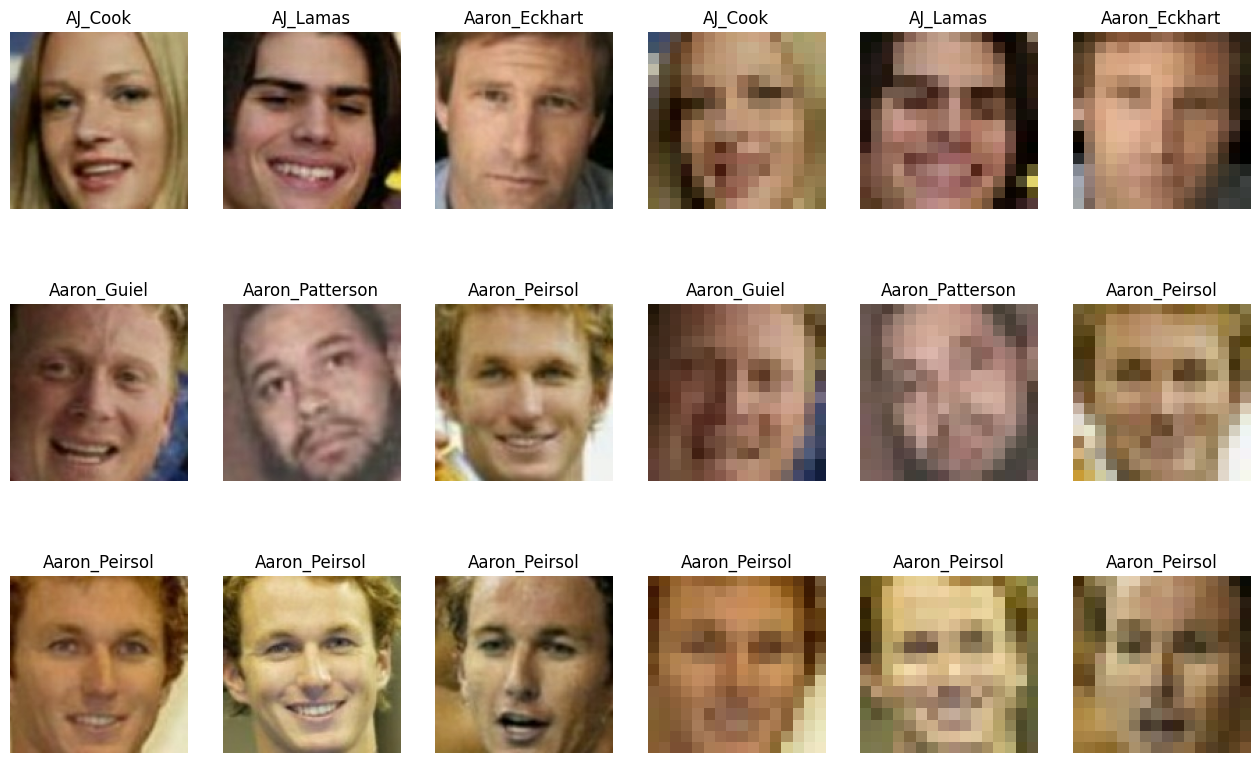

In [ ]:
plt.figure(figsize=(16, 10))
for images, labels in cropped_lfw.take(1):
  for i in range(9):
    index = i + (3 * (i // 3)) + 1
    ax = plt.subplot(3, 6, index)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(cropped_lfw.class_names[labels[i]])
    plt.axis("off")

for images, labels in cropped_lfw_small.take(1):
  for i in range(9):
    index = 3 + i + (3 * (i // 3)) + 1
    ax = plt.subplot(3, 6, index)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(cropped_lfw_small.class_names[labels[i]])
    plt.axis("off")

plt.show()

### Model Creation

In [ ]:
#@title Model definition

class MySubpixelConv2D(Layer):
  def __init__(self, upsampling_factor=4, **kwargs):
    super().__init__(**kwargs)
    self.upsampling_factor = upsampling_factor

  def call(self, inputs):
    return tf.nn.depth_to_space(inputs, self.upsampling_factor)

class UpsamplingGAN():
  def __init__(self,
               content_loss_weight=1,
               adversarial_loss_weight=1,
               lr=1e-4,
               inspect_train_image=None,
               inspect_test_image=None,
               inspect_image_steps=200,
               autosave=10,
               autosave_dir=".",
               weights=None):
    self.inspect_image_steps = inspect_image_steps
    self.inspect_train_image = inspect_train_image
    self.inspect_test_image = inspect_test_image

    self.autosave = autosave
    self.autosave_dir = autosave_dir

    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    train_log_dir = "logs/gradient_tape/" + current_time + "/train"
    test_log_dir = "logs/gradient_tape/" + current_time + "/test"
    self.train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    self.test_summary_writer = tf.summary.create_file_writer(test_log_dir)

    self.generator = self.__make_generator()
    if weights:
      gen_ckpt = tf.train.Checkpoint(generator=self.generator)
      gen_ckpt.restore(
        os.path.join(weights, "generator_weights")
      ).expect_partial()

    # Remove batch size from shape
    generator_output_shape = self.generator.output_shape[1:]
    self.discriminator = self.__make_discriminator(generator_output_shape)
    if weights:
      disc_ckpt = tf.train.Checkpoint(discriminator=self.discriminator)
      disc_ckpt.restore(
        os.path.join(weights, "discriminator_weights")
    ).expect_partial()

    # Define loss
    self.cross_entropy = tf.keras.losses.BinaryCrossentropy()
    self.mse = tf.keras.losses.MeanSquaredError()
    self.content_loss_weight = content_loss_weight
    self.adversarial_loss_weight = adversarial_loss_weight

    # Define optimizers
    self.generator_optimizer = tf.keras.optimizers.Adam(lr)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(lr)

  def __make_generator(self):
    inputs = tf.keras.Input(shape=(None, None, 3))
    x = Conv2D(64, (9, 9), strides=(1, 1), padding="same")(inputs)
    x_temp2 = LeakyReLU()(x)
    x_temp = x_temp2

    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 2
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 3
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 4
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 5
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()((x_temp, x))

    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()((x_temp2, x))

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = MySubpixelConv2D(upsampling_factor=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = MySubpixelConv2D(upsampling_factor=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(3, (9, 9), strides=(1, 1), padding="same", activation="tanh")(x)

    model = tf.keras.Model(inputs, x, name="generator")
    return model

  def __make_discriminator(self, input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(inputs)
    x = LeakyReLU()(x)

    x = Conv2D(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Dense(1024)(x)
    x = LeakyReLU()(x)
    x = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, x, name="discriminator")
    return model

  def generator_loss(self, fake_output):
    return self.cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(self, real_output, fake_output):
    real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

  @tf.function
  def train_step(self, lr, sr):
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = self.generator(lr, training=True)

        real_output = self.discriminator(sr, training=True)
        fake_output = self.discriminator(generated_images, training=True)

        # Compute loss
        content_loss = self.content_loss_weight * self.mse(sr, generated_images)

        gen_loss = self.adversarial_loss_weight * self.generator_loss(fake_output)
        disc_loss = self.discriminator_loss(real_output, fake_output)

        perc_loss = content_loss + gen_loss

      gradients_of_generator = gen_tape.gradient(perc_loss, self.generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

      self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
      self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

      return perc_loss, disc_loss

  @tf.function
  def test_step(self, lr, sr):
    generated_images = self.generator(lr, training=False)

    real_output = self.discriminator(sr, training=False)
    fake_output = self.discriminator(generated_images, training=False)

    # Compute loss
    content_loss = self.content_loss_weight * self.mse(sr, generated_images)

    gen_loss = self.adversarial_loss_weight * self.generator_loss(fake_output)
    disc_loss = self.discriminator_loss(real_output, fake_output)

    perc_loss = content_loss + gen_loss

    return perc_loss, disc_loss

  def fit(self, dataset, validate_dataset, epochs):
    losses = {"loss": [], "val_loss": [], "perc_loss": [], "disc_loss": [], "val_perc_loss": [], "val_disc_loss": []}

    dataset_size = len(dataset)
    validate_dataset_size = len(validate_dataset)

    train_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    step_count = 0
    lrs, srs = next(iter(dataset))
    train_img = self.inspect_train_image or (lrs[0], srs[0])
    lrs, srs = next(iter(validate_dataset))
    test_img = self.inspect_test_image or (lrs[0], srs[0])

    train_subset = list(dataset.unbatch().take(5))
    test_subset = list(validate_dataset.unbatch().take(5))

    best_val_loss = None
    weights_dir = "weights-" + train_start_time

    for epoch in range(epochs):
      print("Epoch %d/%d" % (epoch + 1, epochs))
      total_perc_loss = 0
      total_disc_loss = 0

      epoch_start = time.time()
      elapsed_time = 0
      step_elapsed_time = 0

      for batch, data in enumerate(dataset):
        step_start = time.time()
        step_count += 1

        # Save image for inspection
        if step_count % self.inspect_image_steps == 0:
          self._save_inspect_image(step_count, train_img, test_img)

        lr, sr = data
        perc_loss, disc_loss = self.train_step(lr, sr)

        total_perc_loss += perc_loss
        total_disc_loss += disc_loss
        loss = total_perc_loss + total_disc_loss

        step_end = time.time()
        elapsed_time = datetime.fromtimestamp(step_end - epoch_start).strftime("%s")
        step_elapsed_time = .5 * step_elapsed_time + .5 * (step_end - step_start)

        progress_bar = get_progress_bar(batch, dataset_size)
        print("\r%d/%d %s - %ss %dms/step - loss: %.3f - perc_loss: %.3f - disc_loss: %.3f" % (batch + 1, dataset_size, progress_bar, elapsed_time, step_elapsed_time * 1000, loss / dataset_size, total_perc_loss / dataset_size, total_disc_loss / dataset_size), end="")

      total_perc_loss = total_perc_loss / dataset_size
      total_disc_loss = total_disc_loss / dataset_size
      loss = total_perc_loss + total_disc_loss

      losses["perc_loss"].append(total_perc_loss.numpy())
      losses["disc_loss"].append(total_disc_loss.numpy())
      losses["loss"].append(loss.numpy())

      progress_bar = get_progress_bar(dataset_size, dataset_size)
      print("\r%d/%d %s - %ss %dms/step - loss: %.3f - perc_loss: %.3f - disc_loss: %.3f" % (dataset_size, dataset_size, progress_bar, elapsed_time, step_elapsed_time * 1000, loss, total_perc_loss, total_disc_loss), end="")

      with self.train_summary_writer.as_default():
        tf.summary.scalar("loss", loss, step=epoch)
        tf.summary.scalar("perc_loss", total_perc_loss, step=epoch)
        tf.summary.scalar("disc_loss", total_disc_loss, step=epoch)

      total_val_perc_loss = 0
      total_val_disc_loss = 0

      for batch, val_data in enumerate(validate_dataset):
        lr, sr = val_data
        perc_loss, disc_loss = self.test_step(lr, sr)

        total_val_perc_loss += perc_loss
        total_val_disc_loss += disc_loss

      total_val_perc_loss = total_val_perc_loss / validate_dataset_size
      total_val_disc_loss = total_val_disc_loss / validate_dataset_size
      val_loss = total_val_perc_loss + total_val_disc_loss

      losses["val_perc_loss"].append(total_val_perc_loss.numpy())
      losses["val_disc_loss"].append(total_val_disc_loss.numpy())
      losses["val_loss"].append(val_loss.numpy())

      elapsed_time = datetime.fromtimestamp(time.time() - epoch_start).strftime("%s")
      progress_bar = get_progress_bar(dataset_size, dataset_size)

      print("\r%d/%d %s - %ss %dms/step - loss: %.3f - perc_loss: %.3f - disc_loss: %.3f - val_loss: %.3f - val_perc_loss: %.3f - val_disc_loss: %.3f" % (dataset_size, dataset_size, \
                                  progress_bar, elapsed_time, \
                                  step_elapsed_time * 1000, loss, \
                                  total_perc_loss, \
                                  total_disc_loss, \
                                  val_loss, \
                                  total_val_perc_loss, \
                                  total_val_disc_loss), end="\n")

      with self.test_summary_writer.as_default():
        tf.summary.scalar("val_loss", val_loss, step=epoch)
        tf.summary.scalar("val_perc_loss", total_val_perc_loss, step=epoch)
        tf.summary.scalar("val_disc_loss", total_val_disc_loss, step=epoch)

      # Save best weights until now
      if not best_val_loss or val_loss < best_val_loss:
        best_val_loss = val_loss
        self.save_weights(dir=weights_dir)

      # Autosave of the current training
      if self.autosave and (epoch + 1) % self.autosave == 0:
        self._autosave(epoch, train_start_time, losses, weights_dir, train_subset, test_subset)

    return losses

  def summary(self):
    self.generator.summary()
    self.discriminator.summary()

  def _autosave(self, epoch, start_time, history, best_weights, train_subset, test_subset):
    main_dir = os.path.join(self.autosave_dir, "checkpoints-{}".format(start_time))

    # If the main directory doesn't exists, create it
    if not os.path.exists(main_dir):
      os.mkdir(main_dir)

    # Create the directory of the current checkpoint
    current_time = datetime.now().strftime("%H-%M-%S")
    current_checkpoint_dir = os.path.join(main_dir, "{}_{}".format(epoch + 1, current_time))
    os.mkdir(current_checkpoint_dir)

    # Save history
    history_file = os.path.join(current_checkpoint_dir, "history.json")
    with open(history_file, "w") as f:
      json.dump(str(history), f)

    # Save best weights until now
    best_weights_dir = os.path.join(current_checkpoint_dir, "best_weights")
    if os.path.exists(best_weights):
      shutil.copytree(best_weights, best_weights_dir)

    # Save current weights
    current_weights_dir = os.path.join(current_checkpoint_dir, "weights")
    self.save_weights(dir=current_weights_dir)

    # Save plots
    train_results_path = os.path.join(current_checkpoint_dir, "Train results")
    self.plot_results(train_subset, save_path=train_results_path, save=True, show=False)

    test_results_path = os.path.join(current_checkpoint_dir, "Test results")
    self.plot_results(test_subset, save_path=test_results_path, save=True, show=False)

  def upscale_dataset(self, dataset):
    images = []
    for lr, _ in dataset:
      generated_images = self.upscale_image(lr)
      for image in generated_images:
        images.append(image)
    images = np.array(images)
    return images.reshape(-1, images.shape[-3], images.shape[-2], images.shape[-1])

  def upscale_image(self, lr):
    return self.generator(np.expand_dims(lr, axis=0), training=False)

  def save_weights(self, dir="weights"):
    self.generator.save_weights(os.path.join(dir, "generator_weights"))
    self.discriminator.save_weights(os.path.join(dir, "discriminator_weights"))

In [ ]:
#@title Model definition Canny

class MySubpixelConv2D(Layer):
  def __init__(self, upsampling_factor=4, **kwargs):
    super().__init__(**kwargs)
    self.upsampling_factor = upsampling_factor

  def call(self, inputs):
    return tf.nn.depth_to_space(inputs, self.upsampling_factor)

class UpsamplingGANCanny():
  def __init__(self,
               content_loss_weight=1,
               adversarial_loss_weight=1,
               lr=1e-4, loss_model="vgg",
               inspect_train_image=None,
               inspect_test_image=None,
               inspect_image_steps=200,
               autosave=10,
               autosave_dir=".",
               weights=None):
    self.inspect_image_steps = inspect_image_steps
    self.inspect_train_image = inspect_train_image
    self.inspect_test_image = inspect_test_image

    self.autosave = autosave
    self.autosave_dir = autosave_dir

    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    train_log_dir = "logs/gradient_tape/" + current_time + "/train"
    test_log_dir = "logs/gradient_tape/" + current_time + "/test"
    self.train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    self.test_summary_writer = tf.summary.create_file_writer(test_log_dir)

    self.generator = self.__make_generator()
    if weights:
      gen_ckpt = tf.train.Checkpoint(generator=self.generator)
      gen_ckpt.restore(
        os.path.join(weights, "generator_weights")
      ).expect_partial()

    # Remove batch size from shape
    generator_output_shape = self.generator.output_shape[0][1:]
    self.discriminator = self.__make_discriminator(generator_output_shape)
    if weights:
      disc_ckpt = tf.train.Checkpoint(discriminator=self.discriminator)
      disc_ckpt.restore(
        os.path.join(weights, "discriminator_weights")
    ).expect_partial()

    # Define loss
    self.cross_entropy = tf.keras.losses.BinaryCrossentropy()
    self.mse = tf.keras.losses.MeanSquaredError()
    self.content_loss_weight = content_loss_weight
    self.adversarial_loss_weight = adversarial_loss_weight

    # Define optimizers
    self.generator_optimizer = tf.keras.optimizers.Adam(lr)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(lr)

  def __make_generator(self):
    inputs = tf.keras.Input(shape=(None, None, 3))
    x = Conv2D(64, (9, 9), strides=(1, 1), padding="same")(inputs)
    x_temp2 = LeakyReLU()(x)
    x_temp = x_temp2

    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 2
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 3
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 4
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 5
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()((x_temp, x))

    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()((x_temp2, x))

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = MySubpixelConv2D(upsampling_factor=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = MySubpixelConv2D(upsampling_factor=2)(x)
    last = LeakyReLU()(x)

    super_res = Conv2D(3, (9, 9), strides=(1, 1), padding="same", activation="tanh")(last)
    edges = Conv2D(1, (3, 3), strides=(1, 1), padding="same", activation="sigmoid")(last)

    model = tf.keras.Model(inputs, [super_res, edges], name="generator")
    return model

  def __make_discriminator(self, input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(inputs)
    x = LeakyReLU()(x)

    x = Conv2D(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Dense(1024)(x)
    x = LeakyReLU()(x)
    x = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, x, name="discriminator")
    return model

  def generator_loss(self, fake_output):
    return self.cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(self, real_output, fake_output):
    real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

  @tf.function
  def train_step(self, lr, sr, canny_hr):
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images, canny_upscaled = self.generator(lr, training=True)

        real_output = self.discriminator(sr, training=True)
        fake_output = self.discriminator(generated_images, training=True)

        # Compute loss
        content_loss = self.content_loss_weight * self.mse(sr, generated_images)

        gen_loss = self.adversarial_loss_weight * self.generator_loss(fake_output)
        disc_loss = self.discriminator_loss(real_output, fake_output)

        canny_loss = self.cross_entropy(canny_hr, canny_upscaled)

        perc_loss = content_loss + gen_loss + canny_loss

      gradients_of_generator = gen_tape.gradient(perc_loss, self.generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

      self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
      self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

      return canny_loss, disc_loss

  @tf.function
  def test_step(self, lr, sr, canny_hr):
    generated_images, canny_upscaled = self.generator(lr, training=False)

    real_output = self.discriminator(sr, training=False)
    fake_output = self.discriminator(generated_images, training=False)

    # Compute loss
    content_loss = self.content_loss_weight * self.mse(sr, generated_images)

    gen_loss = self.adversarial_loss_weight * self.generator_loss(fake_output)
    disc_loss = self.discriminator_loss(real_output, fake_output)

    canny_loss = self.cross_entropy(canny_hr, canny_upscaled)

    perc_loss = content_loss + gen_loss + canny_loss

    return perc_loss, disc_loss

  def fit(self, dataset, validate_dataset, epochs):
    losses = {"loss": [], "val_loss": [], "perc_loss": [], "disc_loss": [], "val_perc_loss": [], "val_disc_loss": []}

    dataset_size = len(dataset)
    validate_dataset_size = len(validate_dataset)

    train_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    step_count = 0
    lrs, srs, cannys = next(iter(dataset))
    train_img = self.inspect_train_image or (lrs[0], srs[0])
    lrs, srs, cannys = next(iter(validate_dataset))
    test_img = self.inspect_test_image or (lrs[0], srs[0])

    train_subset = list(dataset.unbatch().take(5))
    test_subset = list(validate_dataset.unbatch().take(5))

    best_val_loss = None
    weights_dir = "weights-" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    for epoch in range(epochs):
      print("Epoch %d/%d" % (epoch + 1, epochs))
      total_perc_loss = 0
      total_disc_loss = 0

      epoch_start = time.time()
      elapsed_time = 0
      step_elapsed_time = 0

      for batch, data in enumerate(dataset):
        step_start = time.time()
        step_count += 1

        lr, sr, canny_hr = data
        perc_loss, disc_loss = self.train_step(lr, sr, canny_hr)

        total_perc_loss += perc_loss
        total_disc_loss += disc_loss
        loss = total_perc_loss + total_disc_loss

        step_end = time.time()
        elapsed_time = datetime.fromtimestamp(step_end - epoch_start).strftime("%s")
        step_elapsed_time = .5 * step_elapsed_time + .5 * (step_end - step_start)

        progress_bar = get_progress_bar(batch, dataset_size)
        print("\r%d/%d %s - %ss %dms/step - loss: %.3f - perc_loss: %.3f - disc_loss: %.3f" % (batch + 1, dataset_size, progress_bar, elapsed_time, step_elapsed_time * 1000, loss / dataset_size, total_perc_loss / dataset_size, total_disc_loss / dataset_size), end="")

      total_perc_loss = total_perc_loss / dataset_size
      total_disc_loss = total_disc_loss / dataset_size
      loss = total_perc_loss + total_disc_loss

      losses["perc_loss"].append(total_perc_loss)
      losses["disc_loss"].append(total_disc_loss)
      losses["loss"].append(loss)

      progress_bar = get_progress_bar(dataset_size, dataset_size)
      print("\r%d/%d %s - %ss %dms/step - loss: %.3f - perc_loss: %.3f - disc_loss: %.3f" % (dataset_size, dataset_size, progress_bar, elapsed_time, step_elapsed_time * 1000, loss, total_perc_loss, total_disc_loss), end="")

      with self.train_summary_writer.as_default():
        tf.summary.scalar("loss", loss, step=epoch)
        tf.summary.scalar("perc_loss", total_perc_loss, step=epoch)
        tf.summary.scalar("disc_loss", total_disc_loss, step=epoch)

      total_val_perc_loss = 0
      total_val_disc_loss = 0

      for batch, val_data in enumerate(validate_dataset):
        lr, sr, canny_hr = val_data
        perc_loss, disc_loss = self.test_step(lr, sr, canny_hr)

        total_val_perc_loss += perc_loss
        total_val_disc_loss += disc_loss

      total_val_perc_loss = total_val_perc_loss / validate_dataset_size
      total_val_disc_loss = total_val_disc_loss / validate_dataset_size
      val_loss = total_val_perc_loss + total_val_disc_loss

      losses["val_perc_loss"].append(total_val_perc_loss)
      losses["val_disc_loss"].append(total_val_disc_loss)
      losses["val_loss"].append(val_loss)

      elapsed_time = datetime.fromtimestamp(time.time() - epoch_start).strftime("%s")
      progress_bar = get_progress_bar(dataset_size, dataset_size)

      print("\r%d/%d %s - %ss %dms/step - loss: %.3f - perc_loss: %.3f - disc_loss: %.3f - val_loss: %.3f - val_perc_loss: %.3f - val_disc_loss: %.3f" % (dataset_size, dataset_size, \
                                  progress_bar, elapsed_time, \
                                  step_elapsed_time * 1000, loss, \
                                  total_perc_loss, \
                                  total_disc_loss, \
                                  val_loss, \
                                  total_val_perc_loss, \
                                  total_val_disc_loss), end="\n")

      with self.test_summary_writer.as_default():
        tf.summary.scalar("val_loss", val_loss, step=epoch)
        tf.summary.scalar("val_perc_loss", total_val_perc_loss, step=epoch)
        tf.summary.scalar("val_disc_loss", total_val_disc_loss, step=epoch)

      # Save best weights until now
      if not best_val_loss or val_loss < best_val_loss:
        best_val_loss = val_loss
        self.save_weights(dir=weights_dir)

      # Autosave of the current training
      if self.autosave and (epoch + 1) % self.autosave == 0:
        self._autosave(epoch, train_start_time, losses, weights_dir, train_subset, test_subset)

    return losses

  def summary(self):
    self.generator.summary()
    self.discriminator.summary()


  def _autosave(self, epoch, start_time, history, best_weights, train_subset, test_subset):
    main_dir = os.path.join(self.autosave_dir, "checkpoints-canny-{}".format(start_time))

    # If the main directory doesn't exists, create it
    if not os.path.exists(main_dir):
      os.mkdir(main_dir)

    # Create the directory of the current checkpoint
    current_time = datetime.now().strftime("%H-%M-%S")
    current_checkpoint_dir = os.path.join(main_dir, "{}_{}".format(epoch + 1, current_time))
    os.mkdir(current_checkpoint_dir)

    # Save history
    history_file = os.path.join(current_checkpoint_dir, "history.json")
    with open(history_file, "w") as f:
      json.dump(str(history), f)

    # Save best weights until now
    best_weights_dir = os.path.join(current_checkpoint_dir, "best_weights")
    if os.path.exists(best_weights):
      shutil.copytree(best_weights, best_weights_dir)

    # Save current weights
    current_weights_dir = os.path.join(current_checkpoint_dir, "weights")
    self.save_weights(dir=current_weights_dir)

    # Save plots
    train_results_path = os.path.join(current_checkpoint_dir, "Train results")
    self.plot_results(train_subset, save_path=train_results_path, save=True, show=False)

    test_results_path = os.path.join(current_checkpoint_dir, "Test results")
    self.plot_results(test_subset, save_path=test_results_path, save=True, show=False)

  def upscale_dataset(self, dataset):
    images = []
    for lr, _ in dataset:
      generated_images = self.upscale_image(lr)
      for image in generated_images:
        images.append(image)
    images = np.array(images)
    return images.reshape(-1, images.shape[-3], images.shape[-2], images.shape[-1])

  def upscale_image(self, lr):
    imgs, _ = self.generator(np.expand_dims(lr, axis=0), training=False)
    return imgs

  def save_weights(self, dir="weights"):
    self.generator.save_weights(os.path.join(dir, "generator_weights"))
    self.discriminator.save_weights(os.path.join(dir, "discriminator_weights"))

In [ ]:
# Instantiate normal GAN
autosave_dir = r"/content/06 - GAN Checkpoints"
gan = UpsamplingGAN(adversarial_loss_weight=0.0001, content_loss_weight=1, lr=1e-4, inspect_image_steps=157, autosave_dir=autosave_dir, autosave=5, weights=None)

In [ ]:
# Instantiate Canny GAN
autosave_dir = r"/content/06 - GAN Checkpoints"
gan = UpsamplingGANCanny(adversarial_loss_weight=0.0001, content_loss_weight=1, lr=1e-4, inspect_image_steps=157, autosave_dir=autosave_dir, autosave=5, weights=None)

In [ ]:
!gdown -q https://drive.google.com/uc?id=1bEKq-ct7jtMo_oztXLhBBl-rhGvYLhXP
!unzip -qn results-2021-10-22_12-49-13.zip
gan = UpsamplingGAN(adversarial_loss_weight=0.0001, content_loss_weight=1, lr=1e-4, inspect_image_steps=157, weights="weights-2021-10-22_10-55-44")

In [ ]:
!gdown -q https://drive.google.com/uc?id=1V5V0L9kEONdmGf9OGc_jiAqU8Yjc4E7R
!unzip -qn results-canny-2021-11-22_17-06-28.zip
canny_gan = UpsamplingGANCanny(adversarial_loss_weight=0.0001, content_loss_weight=1, lr=1e-4, inspect_image_steps=157, weights="weights")

## Models comparison

# Face Recognition

In this section we will define our face recognition model.

## Model definition

In [ ]:
# Add drive in order to save the results
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
identities = cropped_webface_train_ds.class_names
print("Identities:", len(identities))
print("First 5 identities:", identities[:5])

Identities: 1000
First 5 identities: ['0000045', '0000099', '0000100', '0000102', '0000103']


In [ ]:
base_model = tf.keras.applications.resnet.ResNet50(input_shape=(None, None, 3), include_top=False, weights="imagenet")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.trainable = True

inputs = tf.keras.Input(shape=(None, None, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(len(identities), activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, None,      │          0 │ input_layer_9[0]… │
│                     │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, None,      │          0 │ input_layer_9[0]… │
│ (GetItem)           │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, None,      │          0 │ input_layer_9[0]… │
│ (GetItem)           │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, None,      │          0 │ get_item[0][0],   │
│                     │ None, 3)          │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, None,      │          0 │ stack[0][0]       │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, None,      │ 23,587,712 │ add_24[0][0]      │
│ (Functional)        │ None, 2048)       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1000)      │  2,049,000 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

## Model Training

In [ ]:
history = model.fit(cropped_webface_train_ds, epochs=3, validation_data=cropped_webface_validate_ds)

Epoch 1/3
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 233s 126ms/step - acc: 0.3816 - loss: 3.0391 - val_acc: 0.4300 - val_loss: 2.9232
Epoch 2/3
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 262s 126ms/step - acc: 0.5725 - loss: 2.0566 - val_acc: 0.5286 - val_loss: 2.4498
Epoch 3/3
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 269s 130ms/step - acc: 0.6959 - loss: 1.4171 - val_acc: 0.5562 - val_loss: 2.3867


In [ ]:
# Save history to file
with open("history.json", "w") as f:
  json.dump(history.history, f)

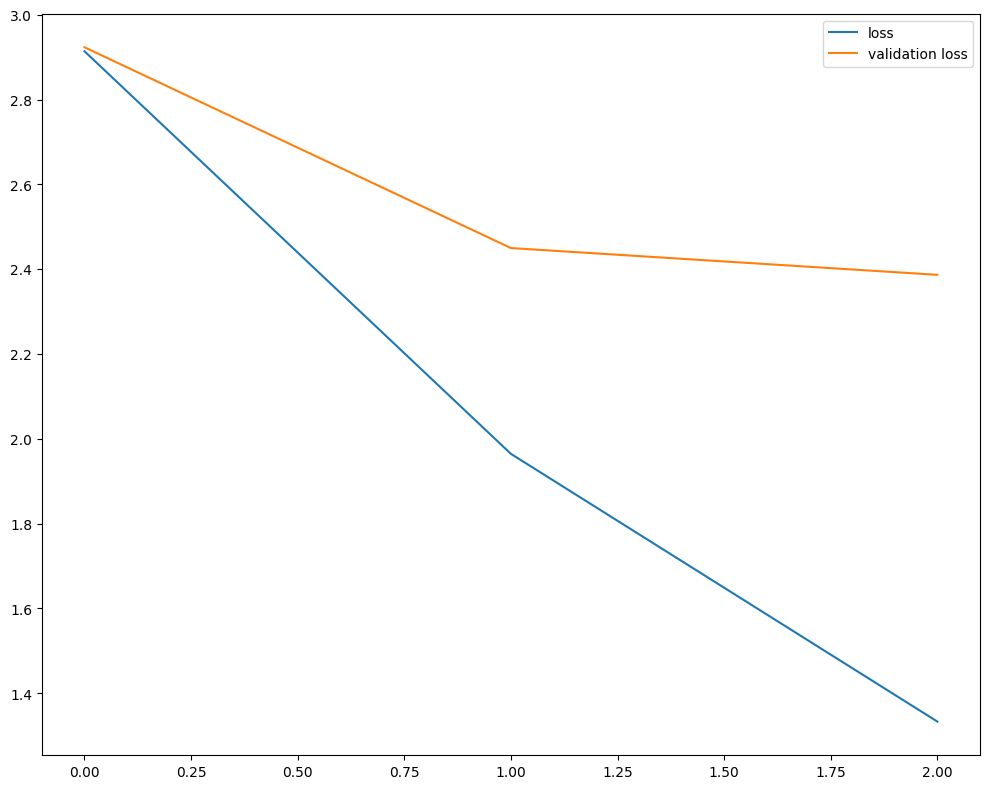

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "validation loss"])
plt.tight_layout()
plt.savefig("loss.png")
plt.show()

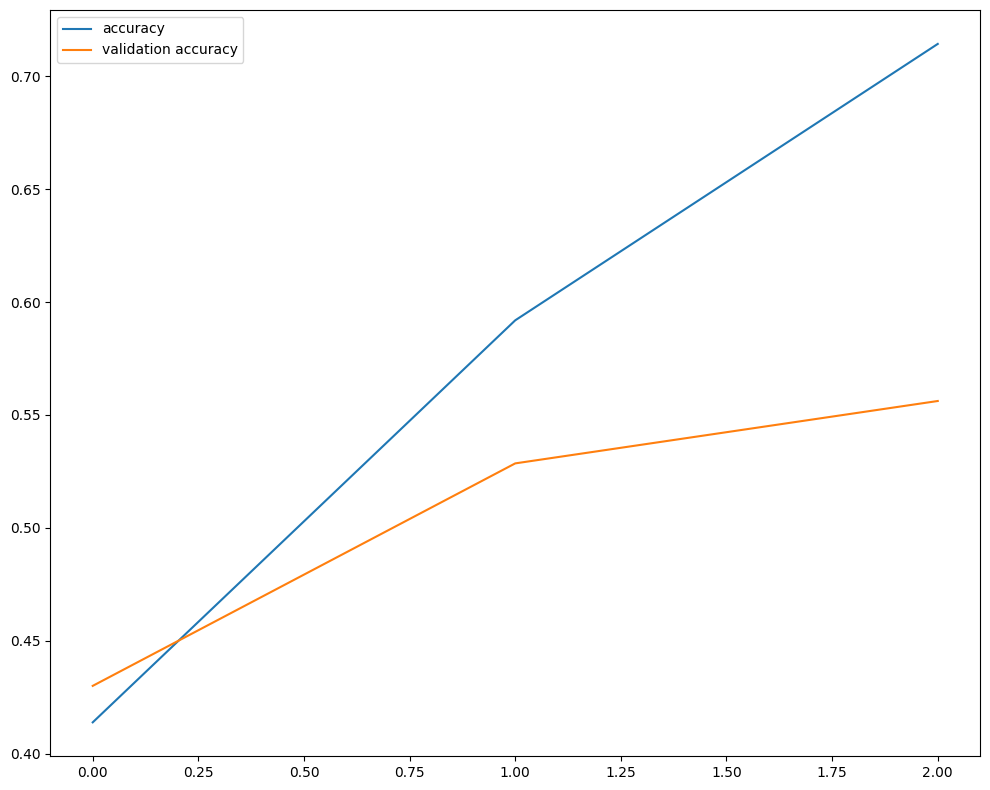

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend(["accuracy", "validation accuracy"])
plt.tight_layout()
plt.savefig("accuracy.png")
plt.show()

## Save model

In [ ]:
model_name = "resnet-imagenet-trainable-1000x128x128-10_epochs.h5"
model.save(model_name)

In [ ]:
output = model_name + ".zip"
!zip -r "$output" "$model_name"

  adding: resnet-imagenet-trainable-1000x128x128-10_epochs.h5 (deflated 7%)


In [ ]:
target = os.path.join(r"/content/03 - Models", model_name)
os.mkdir(target)
shutil.copy(output, os.path.join(target, output))
shutil.copy("history.json", os.path.join(target, "history.json"))
shutil.copy("loss.png", os.path.join(target, "loss.png"))
shutil.copy("accuracy.png", os.path.join(target, "accuracy.png"))
shutil.copy("model.png", os.path.join(target, "model.png"))

FileNotFoundError: [Errno 2] No such file or directory: '/content/03 - Models/resnet-imagenet-trainable-1000x128x128-10_epochs.h5'

## Load model

In [ ]:
#@title Download best model
!gdown -q https://drive.google.com/uc?id=1-3sWnSb46R4tjoix490_cBfwYoJ5E-Ko
!unzip -qn "resnet-imagenet-trainable-1000x128x128-10_epochs (Final).zip"

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("resnet-imagenet-trainable-1000x128x128-10_epochs (Final)")
model.summary()

## Inspect results

In [ ]:
images, labels = next(iter(cropped_webface_train_ds))
i = 0
plt.imshow(images[i].numpy().astype(np.uint8))
plt.show()

prediction = model.predict(np.array([images[i]]))
identity = np.argmax(prediction[0])

print("Predicted", identities[identity])
print("True", identities[labels[i]])

In [ ]:
import random
images, labels = next(iter(cropped_webface_validate_ds))
i = int(random.random() * len(images))

plt.imshow(images[i].numpy().astype(np.uint8))
plt.show()

prediction = model.predict(np.array([images[i]]))

identity = np.argmax(prediction[0])

print("Predicted", identities[identity])
print("True", identities[labels[i]])

In [ ]:
def upscale_dataset(dataset, upscale_fn, save_dir):
  """
  Upscale an entire dataset to `target_size` using `upscale_fn` to upscale an image
  and saving the results in `save_dir`.
  """
  total_size = len(dataset.file_paths)

  # Remove previous directory if exists
  if os.path.exists(save_dir):
    import shutil
    shutil.rmtree(save_dir)

  os.mkdir(save_dir)

  i = 0
  for images, labels in dataset:
    upscaled_images = []

    # Crop images for a batch
    for image, label in zip(images, labels):
      if i % 10 == 0:
        progress_bar = get_progress_bar(i, total_size)
        percent = int(i / total_size * 100)
        print("\r%s%% %s Upscaling and saving to disk %d/%d..." % (percent, progress_bar, i, total_size), end="")

      upscaled_image = upscale_fn(image)
      upscaled_images.append(upscaled_image)

      image_path = dataset.file_paths[i]
      orig_folder = os.path.basename(os.path.dirname(image_path))
      path = os.path.join(save_dir, orig_folder)
      if not os.path.exists(path):
        os.makedirs(path)

      filename = os.path.basename(image_path)
      cv.imwrite(os.path.join(path, filename), upscaled_image)

      i += 1

  progress_bar = get_progress_bar(len(dataset), len(dataset))
  print("\r%s%% %s Upscaled with success %d images" % (100, progress_bar, total_size))

def opencv_upscale(size):
  def _resize(image):
    uint_image = image.numpy().astype(np.uint8)
    bgr_image = cv.cvtColor(uint_image, cv.COLOR_BGR2RGB)
    return cv.resize(bgr_image, size)
  return _resize

def gan_upscale(model):
  def _resize(image):
    image = (image - 127.5) / 127.5
    upscaled_image = model.upscale_image(image)[0]
    uint_image = (upscaled_image * 127.5 + 127.5).numpy().astype(np.uint8)
    return cv.cvtColor(uint_image, cv.COLOR_BGR2RGB)
  return _resize

In [ ]:
upscale_dataset(cropped_lfw_small, opencv_upscale((128, 128)), "lfw-upscaled-opencv")

In [ ]:
upscale_dataset(cropped_lfw_small, gan_upscale(gan), "lfw-upscaled-gan")

In [ ]:
!zip -qr lfw-upscaled-128-opencv.zip lfw-upscaled-opencv
!zip -qr lfw-upscaled-128-gan.zip lfw-upscaled-gan
!zip -qr lfw-upscaled-128-canny-gan.zip lfw-upscaled-canny-gan

In [ ]:
!cp lfw-upscaled-128-opencv.zip "/content/01 - Dataset"
!cp lfw-upscaled-128-gan.zip "/content/01 - Dataset"
!cp lfw-upscaled-128-canny-gan.zip "/content/01 - Dataset"

# Evaluation

In this section we evaluate the performances of our models. Moreover, we compare the results of our model with the VGG-Face, implemented in the [DeepFace](https://github.com/serengil/deepface) package of Python.

In [ ]:
!pip -q install deepface
from deepface import DeepFace

In [ ]:
files = {
  "lfw-upscaled-128-opencv.zip": "19c75BhfAY38-7f4FG4abVJ74VObg8TTE",
  "lfw-upscaled-128-gan.zip": "1UgBlWdoxOfIhv8QEFXrFkPqmy0W1WgIG",
  "lfw-upscaled-128-canny-gan.zip": "1FOxXcDo5iJDSTIOkBLpduneKjukWObZ3",
}

download_datasets(files)

In [ ]:
DATASET_NAME = "lfw-upscaled-gan"

In [ ]:
evaluation_dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/" + DATASET_NAME, image_size=(32, 32) if DATASET_NAME == "cropped-lfw-32" else (128, 128), shuffle=False)
print("Loaded dataset", DATASET_NAME)

In [ ]:
MODEL_NAME = "Ours"

### Precompute templates

In [ ]:
# Get the size of the dataset
total = len(evaluation_dataset.file_paths)

imgs, _ = next(iter(evaluation_dataset))
w, h, c = imgs[0].shape

templates = np.zeros((total, 2048 if MODEL_NAME == "Ours" else 2622))
images = np.zeros((total, w, h, c))
labels = []

# The following dict is going to contain the name of the identities
# and for each of them there is going to be another mapping
# that given the number of an image is going to retrieve the index of
# that image in the previously defined vectors
# e.g. { Identity -> n.img -> index in the templates, images, labels vectors}
identities_mapping = {}

i = 0

# Create a new model without the last two layers in order to obtain the templates as output
template_model = tf.keras.Model(model.input, model.layers[-2].output)

last_i = 0
last_time = time.time()
delta = 0

for batch_images, batch_labels in evaluation_dataset:
  # Get the file names
  file_names = evaluation_dataset.file_paths[i:i+len(batch_images)]

  # Obtain the templates for the images
  if MODEL_NAME != "Ours":
    out_templates = [DeepFace.represent(image.numpy().astype(np.uint8), model_name=MODEL_NAME, enforce_detection=False) for image in batch_images]
    out_templates = np.array(out_templates)
  else:
    out_templates = template_model.predict(batch_images)

  templates[i:i+len(batch_images)] = out_templates
  images[i:i+len(batch_images)] = batch_images

  # Get the identities from the labels
  identities = [evaluation_dataset.class_names[l] for l in batch_labels]
  labels += identities

  for j in range(len(identities)):
    identity = identities[j]
    file_name = os.path.basename(file_names[j])

    if identity not in identities_mapping:
      identities_mapping[identity] = {}

    # Compute the number of template from the filename and add it to the mapping
    name_without_ext = os.path.splitext(file_name)[0]
    num_template = int(name_without_ext.split("_")[-1])
    identities_mapping[identity][num_template] = i

    i += 1

  if time.time() - last_time >= 1:
    delta = i - last_i
    last_time = time.time()
    last_i = i
    print("\r", get_progress_bar(i, total), "{}/{}".format(i, total), delta, "images/sec", end="")

labels = np.array(labels)

print("\r", get_progress_bar(total, total), "{}/{}".format(total, total), delta, "images/sec")

### Compute distance matrix

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

M = 1 - cosine_similarity(templates, templates)
M

We fill the diagonal with `inf` since we want to ignore the distance with the same template which will be always 0.
In this way when we will sort the distances, the distance with itself will be the last one and we will be able to efficiently remove that just using the `pop()` method.

In [ ]:
np.fill_diagonal(M, np.inf)
M.round(2)

## All-Against-All

Based on the code provided during the lectures, in this section, we perform the All-Against-All validation method using the LFW dataset.

### Evaluation

In [ ]:
thresholds = np.arange(0, 1 + .05, .05)
thresholds

In [ ]:
def find_k(distances, L, label, th, same_label=True):
  """
  Find the rank of the first identity which has a score below the threshold
  and label equal to the one provided or diffrent from it, according to the same_label argument.
  """
  for k in range(1, len(L)):
    index = L[k]
    distance = distances[index]
    if distance > th:
      return None
    if same_label and labels[index] == label:
      return k
    if not same_label and labels[index] != label:
      return k
  return None

TG = TI = len(labels)

num_thresholds = len(thresholds)

DIR = np.zeros((num_thresholds, len(labels)+1))
FRR = np.zeros((num_thresholds))
FAR = np.zeros((num_thresholds))
GRR = np.zeros((num_thresholds))

total_size = num_thresholds * len(M)

for th_index, t in enumerate(thresholds):
  DI = [0 for _ in range(len(labels) + 1)]
  GR = 0
  FA = 0

  for i in range(len(M)):

    if i % 100 == 0:
      index = th_index * len(M) + i
      progress_bar = get_progress_bar(index, total_size)
      percent = int(index / total_size * 100)
      print("\r%s%% %s Computing All-Against-All %d/%d %d/%d..." % (percent, progress_bar, th_index, num_thresholds, i, len(M)), end="")

    label = labels[i]

    L = np.argsort(M[i])

    first_subject_index = L[0]
    first_subject_distance = M[i][first_subject_index]
    first_subject_label = labels[first_subject_index]

    if first_subject_distance <= t:
      if first_subject_label == label:
        # Genuine case
        DI[1] += 1

        # Impostor case (gallery without true identity)
        if find_k(M[i], L, label, t, same_label=False):
          FA += 1
      else:
        # Genuine case
        k = find_k(M[i], L, label, t, same_label=True)
        if k:
          DI[k + 1] += 1

        # Impostor case
        FA += 1
    else:
      GR += 1

  DIR[th_index, 1] = DI[1] / TG
  FRR[th_index] = 1 - DIR[th_index, 1]
  FAR[th_index] = FA / TI
  GRR[th_index] = GR / TI

  # Compute DIR for other ranks
  for k in range(2, len(DI)):
    DIR[th_index, k] = DI[k] / TG + DIR[th_index, k-1]

progress_bar = get_progress_bar(total_size, total_size)
print("\r%s%% %s Computing All-Against-All %d/%d %d/%d..." % (100, progress_bar, num_thresholds, num_thresholds, len(M), len(M)))

RR = DIR[:, 1]

print("Detection and Identification:")
print(DIR.round(2), "\n")

print("Recognition Rate:")
print(RR.round(2), "\n")

print("False Rejection Rate:")
print(FRR.round(2), "\n")

print("False Acceptance Rate:")
print(FAR.round(2), "\n")

print("Genuine Rejection Rate:")
print(GRR.round(2), "\n")

In [ ]:
from sklearn.metrics import auc

auc_score = auc(FAR, RR)

plt.plot([0, 1], [0, 1], color="r")
plt.plot(FAR, RR)
plt.xlabel("FAR")
plt.ylabel("1 - FRR")
plt.title("AAA AUC: {:.5f}".format(auc_score))
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.savefig("all_against_all_auc.png")
plt.show()

In [ ]:
index = np.nanargmin(np.absolute(FRR - FAR))
EER = FRR[index]
best_th_aaa = thresholds[index]
best_th_aaa, EER

In [ ]:
plt.plot(thresholds, FAR, label="FAR")
plt.plot(thresholds, FRR, label="FRR")
plt.xticks(np.arange(0, 1.1, .1))
plt.plot(thresholds, [EER for _ in range(len(thresholds))])
plt.legend()
plt.show()

In [ ]:
print("Recognition Rate (DIR@1):", DIR[index, 1].round(2))
print("DIR@5:", DIR[index, 5].round(2))
print("DIR@10:", DIR[index, 10].round(2))
print("DIR@20:", DIR[index, 20].round(2))
print("DIR@40:", DIR[index, 40].round(2))
print("FRR:", FRR[index].round(2))
print("FAR:", FAR[index].round(2))
print("GRR:", GRR[index].round(2))

### Playground

Little playground to see how the model is performing with a random probe.

In [ ]:
i = np.random.randint(0, len(templates))
plt.suptitle("Source template:\n" + labels[i])
plt.imshow(images[i].astype(np.uint8))
plt.show()

similar_templates = np.argsort(M[i])
plt.figure(figsize=(18, 8))
for j in range(5):
  plt.subplot(1, 5, j+1)
  idx = similar_templates[j]
  plt.imshow(images[idx].astype(np.uint8))
  plt.title(labels[idx] + "\nDistance:" + str(M[i][idx]))
plt.show()

## Standard LFW Evaluation

Since there is a specific protocol for evaluating models performances on the LFW dataset, we decided to evalutate our methods also with this one. It consists in checking if the model can correctly recognize if a pair of templates belong to the same identity or they are two different people.

So, first of all let's download the file containing the test set (pairs):

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/pairs.txt

Let's now parse it in order to make it easier to work with that:

In [ ]:
def parse_pairs(path):
  with open(path) as file:
    folds = []
    first_line = file.readline().split()
    # The first line contains the number of folds and the number of records in each fold.
    # Each fold contains the same number of matched and mismatched pairs.
    # This means that a fold contains n_records * 2 records in total.
    n_folds, n_records = int(first_line[0]), int(first_line[1])
    for n_fold in range(n_folds):
      fold = []
      # Matched pairs
      # Since the identities match, it's only indicated the identity and the two numbers of the templates
      for i in range(n_records):
        data = file.readline().split()
        label, img1, img2 = data[0], int(data[1]), int(data[2])
        fold.append((1, (label, img1, img2)))
      # Mismatched pairs
      # It's indicated the two identities and the two numbers of the templates
      for i in range(n_records):
        data = file.readline().split()
        label, img1, label2, img2 = data[0], int(data[1]), data[2], int(data[3])
        fold.append((0, (label, img1, label2, img2)))
      folds.append(fold)
  return folds

folds = parse_pairs("pairs.txt")
print("Number of folds:", len(folds))
print("Number of records for each fold:", len(folds[0]))
folds[0][:5]

### Evaluation

In [ ]:
from sklearn.metrics import auc
thresholds = np.arange(0, 1 + .05, .05)
thresholds

In [ ]:
AUCS = []
accuracies = []

for i, fold in enumerate(folds):
  TPS = []
  FPS = []
  TNS = []
  FNS = []
  for th in thresholds:
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for record in fold:
      label, data = record
      if label == 1:
        # Matching pair
        identity, num_template1, num_template2 = data

        try:
          identity_templates = identities_mapping[identity]
          template1_id = identity_templates[num_template1]
          template2_id = identity_templates[num_template2]

          cos = 1 - M[template1_id][template2_id]
          if cos >= th:
            TP += 1
          else:
            FN += 1
        except KeyError:
          # We didn't detect a face, so we consider this case as an error
          # since the system would reject the person
          FN += 1
      else:
        # Mismatched pair
        identity1, num_template1, identity2, num_template2 = data

        try:
          template1_id = identities_mapping[identity1][num_template1]
          template2_id = identities_mapping[identity2][num_template2]
          cos = 1 - M[template1_id][template2_id]
          if cos >= th:
            FP += 1
          else:
            TN += 1
        except KeyError:
          # We didn't detect a face, so in this case we output false,
          # since the system is going to reject the person
          TN += 1
    TPS.append(TP)
    FPS.append(FP)
    TNS.append(TN)
    FNS.append(FN)

  TPS = np.array(TPS)
  FPS = np.array(FPS)
  TNS = np.array(TNS)
  FNS = np.array(FNS)

  TPRS = TPS / (TPS + FNS)
  FPRS = FPS / (FPS + TNS)

  plt.plot(FPRS, TPRS, label="Fold " + str(i+1))
  plt.xlim(0, 1)
  plt.ylim(0, 1)

  auc_score = auc(FPRS, TPRS)
  accuracy = (TPS + TNS) / (TPS + FPS + TNS + FNS)

  best_acc = np.max(accuracy)
  best_th_lfw = thresholds[np.argmax(accuracy)]
  print("Fold [{}] \t auc_score: {:.4f} \t best_accuracy: {:.4f} \t best_threshold: {:.4f}".format(i+1, auc_score, best_acc, best_th_lfw))

  AUCS.append(auc_score)
  accuracies.append(accuracy)

print()
mean_acc = np.mean(accuracies, axis=0)
best_th_lfw = thresholds[np.argmax(mean_acc)]
print("Results - mean_accuracy: {:.4f} best_threshold: {:.4f}".format(np.max(mean_acc), best_th_lfw))
print()

plt.legend()
plt.suptitle("Standard LFW average AUC: " + str(np.mean(AUCS)))
plt.savefig("standard_lfw_auc.png")
plt.show()

In [ ]:
!pip install lpips facenet_pytorch torchvision opencv-python pytorch-msssim

In [ ]:
!unzip -q /content/drive/MyDrive/CelebA_128x128_HR.zip -d /content/CelebA_128x128_HR
!unzip -q /content/drive/MyDrive/CelebA_8x8_LR.zip -d /content/CelebA_8x8_LR

In [ ]:
#Training Loop- Already Done

'''import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import cv2

# Evaluation metrics and additional libraries:
from pytorch_msssim import ssim  # pip install pytorch-msssim
import lpips  # pip install lpips
from facenet_pytorch import InceptionResnetV1

#############################################
# Helper Functions
#############################################
def unnormalize(img):
    """Convert an image from [-1, 1] to [0, 1]."""
    return (img + 1) / 2

def compute_psnr(sr, hr):
    """Compute PSNR given two images (assumed to be in [0, 1])."""
    mse = F.mse_loss(sr, hr)
    psnr = 10 * torch.log10(1 / mse)
    return psnr

def get_angles_from_output(logits, idx_tensor, a, b):
    """
    Convert the output logits from Hopenet to an expected angle.
    The predicted angle = a + (b - a) / (num_bins - 1) * sum_i i * p_i,
    where p_i is the softmax probability for bin i.
    """
    prob = F.softmax(logits, dim=1)
    expected = torch.sum(prob * idx_tensor, dim=1)
    angle = a + (b - a) / (len(idx_tensor) - 1) * expected
    return angle

#############################################
# Dataset Definition (assumed same as in training)
#############################################
class FaceSRDataset(torch.utils.data.Dataset):
    def __init__(self, hr_dir, lr_dir):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.hr_files = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir)
                                if f.lower().endswith(('png', 'jpg', 'jpeg'))])
        self.lr_files = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir)
                                if f.lower().endswith(('png', 'jpg', 'jpeg'))])
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # Normalize to [-1, 1]
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.hr_files)

    def __getitem__(self, idx):
        hr_img = cv2.imread(self.hr_files[idx])
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
        lr_img = cv2.imread(self.lr_files[idx])
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
        return {
            'lr': self.transform(lr_img),
            'hr': self.transform(hr_img)
        }

#############################################
# Model Definitions (use your existing code)
#############################################
# Bottleneck Block (as in your training script)
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * Bottleneck.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * Bottleneck.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

# Hopenet Definition (same as in your training script)
class Hopenet(nn.Module):
    def __init__(self, block, layers, num_bins):
        self.inplanes = 64
        super(Hopenet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_yaw = nn.Linear(512 * block.expansion, num_bins)
        self.fc_pitch = nn.Linear(512 * block.expansion, num_bins)
        self.fc_roll = nn.Linear(512 * block.expansion, num_bins)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        pre_yaw = self.fc_yaw(x)
        pre_pitch = self.fc_pitch(x)
        pre_roll = self.fc_roll(x)
        return pre_yaw, pre_pitch, pre_roll

# Generator (MSGenerator) definition
class RRDB(nn.Module):
    def __init__(self, channels):
        super(RRDB, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        out = self.lrelu(self.conv1(x))
        out = self.conv2(out)
        return x + out * 0.2

class MSGenerator(nn.Module):
    def __init__(self):
        super(MSGenerator, self).__init__()
        self.initial = nn.Conv2d(3, 64, 3, 1, 1)
        self.rrdb = nn.Sequential(*[RRDB(64) for _ in range(16)])
        # Upsampling stages:
        self.up1 = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2)
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2)
        )
        self.up3 = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2)
        )
        # Intermediate RGB conversion layers
        self.rgb_s1 = nn.Conv2d(64, 3, 3, 1, 1)
        self.rgb_s2 = nn.Conv2d(64, 3, 3, 1, 1)
        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        feats = self.rrdb(x)
        s1_feat = self.up1(feats)      # Scale 1 feature map
        s1 = self.rgb_s1(s1_feat)        # Scale 1 RGB output

        s2_feat = self.up2(s1_feat)      # Scale 2 feature map
        s2 = self.rgb_s2(s2_feat)        # Scale 2 RGB output

        s3 = self.up3(s2_feat)           # Final scale feature map
        out = self.final(s3)             # Final RGB output
        return [s1, s2, out]

#############################################
# Device Setup
#############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#############################################
# Load Pre-trained Models for Metrics
#############################################
# FaceNet for identity (if needed for further analysis)
facenet = InceptionResnetV1(pretrained='vggface2').to(device).eval()

# Instantiate Hopenet (with ResNet-50-like layers [3, 4, 6, 3] and 66 bins)
num_bins = 66
hopenet = Hopenet(Bottleneck, [3, 4, 6, 3], num_bins).to(device)
# === Update this path to your local hopenet weights file ===
hopenet_weights_path = "/content/hopenet_alpha2.pkl"
hopenet.load_state_dict(torch.load(hopenet_weights_path, map_location=device), strict=False)
hopenet.eval()

# Freeze parameters of FaceNet and Hopenet
for param in list(facenet.parameters()) + list(hopenet.parameters()):
    param.requires_grad = False

# Instantiate LPIPS metric (expects images in [-1, 1])
lpips_fn = lpips.LPIPS(net='alex').to(device)

# Create an index tensor for converting Hopenet logits to angles
idx_tensor = torch.arange(num_bins).float().to(device)

#############################################
# Load the Generator Checkpoint
#############################################
# Instantiate the generator
generator = MSGenerator().to(device)

# Path to your checkpoint file (adjust if needed)
checkpoint_path = "/content/checkpoint_lastest.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()
print("Loaded generator checkpoint from:", checkpoint_path)

#############################################
# Setup Dataset and DataLoader (Update paths as needed)
#############################################
hr_dir = "/content/CelebA_128x128_HR"  # Replace with your HR images folder
lr_dir = "/content/CelebA_8x8_LR"       # Replace with your LR images folder

dataset = FaceSRDataset(hr_dir, lr_dir)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

#############################################
# Evaluation Loop: Compute Metrics
#############################################
total_psnr = 0
total_ssim = 0
total_lpips = 0
total_hpe_mae_yaw = 0
total_hpe_mae_pitch = 0
total_hpe_mae_roll = 0
count = 0

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Evaluating"):
        lr = batch['lr'].to(device)
        hr = batch['hr'].to(device)

        # Get SR outputs (using the final scale output)
        sr_list = generator(lr)
        sr = sr_list[-1]

        # Unnormalize images for PSNR and SSIM (convert from [-1,1] to [0,1])
        sr_unnorm = unnormalize(sr)
        hr_unnorm = unnormalize(hr)

        # Compute PSNR and SSIM
        psnr_val = compute_psnr(sr_unnorm, hr_unnorm)
        ssim_val = ssim(sr_unnorm, hr_unnorm, data_range=1.0, size_average=True)
        total_psnr += psnr_val.item() * lr.size(0)
        total_ssim += ssim_val.item() * lr.size(0)

        # Compute LPIPS (expects images in [-1,1])
        lpips_val = lpips_fn(sr, hr).mean()
        total_lpips += lpips_val.item() * lr.size(0)

        # Head Pose Estimation via Hopenet:
        hr_yaw, hr_pitch, hr_roll = hopenet(hr)
        sr_yaw, sr_pitch, sr_roll = hopenet(sr)

        # Convert logits to angles (assume angle range is [-99, 99])
        yaw_gt = get_angles_from_output(hr_yaw, idx_tensor, a=-99, b=99)
        pitch_gt = get_angles_from_output(hr_pitch, idx_tensor, a=-99, b=99)
        roll_gt = get_angles_from_output(hr_roll, idx_tensor, a=-99, b=99)

        yaw_pred = get_angles_from_output(sr_yaw, idx_tensor, a=-99, b=99)
        pitch_pred = get_angles_from_output(sr_pitch, idx_tensor, a=-99, b=99)
        roll_pred = get_angles_from_output(sr_roll, idx_tensor, a=-99, b=99)

        mae_yaw = torch.mean(torch.abs(yaw_pred - yaw_gt))
        mae_pitch = torch.mean(torch.abs(pitch_pred - pitch_gt))
        mae_roll = torch.mean(torch.abs(roll_pred - roll_gt))
        total_hpe_mae_yaw += mae_yaw.item() * lr.size(0)
        total_hpe_mae_pitch += mae_pitch.item() * lr.size(0)
        total_hpe_mae_roll += mae_roll.item() * lr.size(0)

        count += lr.size(0)

# Compute average metrics
avg_psnr = total_psnr / count
avg_ssim = total_ssim / count
avg_lpips = total_lpips / count
avg_hpe_yaw = total_hpe_mae_yaw / count
avg_hpe_pitch = total_hpe_mae_pitch / count
avg_hpe_roll = total_hpe_mae_roll / count

print("\n--- Evaluation Metrics ---")
print(f"PSNR: {avg_psnr:.2f} dB")
print(f"SSIM: {avg_ssim:.4f}")
print(f"LPIPS: {avg_lpips:.4f}")
print(f"HPE MAE (Yaw): {avg_hpe_yaw:.2f}°, (Pitch): {avg_hpe_pitch:.2f}°, (Roll): {avg_hpe_roll:.2f}°")'''

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import cv2
from facenet_pytorch import InceptionResnetV1

#############################################
# Dataset Definition
#############################################
class FaceSRDataset(torch.utils.data.Dataset):
    def __init__(self, hr_dir, lr_dir):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.hr_files = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir)
                                if f.lower().endswith(('png', 'jpg', 'jpeg'))])
        self.lr_files = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir)
                                if f.lower().endswith(('png', 'jpg', 'jpeg'))])
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # Normalize to [-1, 1]
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.hr_files)

    def __getitem__(self, idx):
        hr_img = cv2.imread(self.hr_files[idx])
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
        lr_img = cv2.imread(self.lr_files[idx])
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
        return {
            'lr': self.transform(lr_img),
            'hr': self.transform(hr_img)
        }

#############################################
# Generator (MSGenerator) Definition
#############################################
# RRDB block used inside MSGenerator
class RRDB(nn.Module):
    def __init__(self, channels):
        super(RRDB, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        out = self.lrelu(self.conv1(x))
        out = self.conv2(out)
        return x + out * 0.2

class MSGenerator(nn.Module):
    def __init__(self):
        super(MSGenerator, self).__init__()
        self.initial = nn.Conv2d(3, 64, 3, 1, 1)
        self.rrdb = nn.Sequential(*[RRDB(64) for _ in range(16)])
        # Upsampling stages:
        self.up1 = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2)
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2)
        )
        self.up3 = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2)
        )
        # Intermediate RGB conversion layers (if needed)
        self.rgb_s1 = nn.Conv2d(64, 3, 3, 1, 1)
        self.rgb_s2 = nn.Conv2d(64, 3, 3, 1, 1)
        # Final output layer
        self.final = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        feats = self.rrdb(x)
        s1_feat = self.up1(feats)      # Intermediate scale output (if needed)
        s1 = self.rgb_s1(s1_feat)
        s2_feat = self.up2(s1_feat)      # Intermediate scale output (if needed)
        s2 = self.rgb_s2(s2_feat)
        s3 = self.up3(s2_feat)           # Final scale output
        out = self.final(s3)
        return [s1, s2, out]  # Return list of outputs; we use the final output

#############################################
# Device Setup
#############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#############################################
# Load Pre-trained FaceNet
#############################################
facenet = InceptionResnetV1(pretrained='vggface2').to(device).eval()

#############################################
# Load Generator Checkpoint
#############################################
generator = MSGenerator().to(device)
checkpoint_path = "/content/checkpoint_lastest.pth"  # Update this path as needed
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()
print("Loaded generator checkpoint from:", checkpoint_path)

#############################################
# Setup Dataset and DataLoader
#############################################
hr_dir = "/content/CelebA_128x128_HR"  # Replace with your HR images folder
lr_dir = "/content/CelebA_8x8_LR"       # Replace with your LR images folder
dataset = FaceSRDataset(hr_dir, lr_dir)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

#############################################
# Face Recognition Testing
#############################################
# In this test, we treat the HR image as the gallery and compare its embedding with the SR image (probe)
cosine_threshold = 0.1  # Example threshold; adjust based on your validation results
total_samples = 0
correct_matches = 0

all_scores = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Collecting scores"):
        lr = batch['lr'].to(device)
        hr = batch['hr'].to(device)
        sr = generator(lr)[-1]

        # Embeddings
        emb_hr = facenet(hr)
        emb_sr = facenet(sr)

        # Positive (genuine) scores
        cos_pos = F.cosine_similarity(emb_hr, emb_sr, dim=1)
        all_scores.extend(cos_pos.cpu().numpy())
        all_labels.extend([1]*len(cos_pos))

        # Negative (impostor) scores: shuffle SR embeddings within the batch
        perm = torch.randperm(emb_sr.size(0))
        emb_sr_neg = emb_sr[perm]
        cos_neg = F.cosine_similarity(emb_hr, emb_sr_neg, dim=1)
        all_scores.extend(cos_neg.cpu().numpy())
        all_labels.extend([0]*len(cos_neg))

# Convert to arrays
scores = np.array(all_scores)
labels = np.array(all_labels)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: CelebA')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()